In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import arange
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter('ignore')

In [2]:
## Calulcating metrics
def calculate_metrics(df, crop_names, y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)
    y_test_avg = pd.DataFrame(y_test).mean().iloc[0]
    y_pred_avg = pd.DataFrame(y_pred).mean().iloc[0]
    df.loc[crop_names] = [mae, mse, rmse, mape, r2, y_test_avg, y_pred_avg]


In [10]:
fao_data = pd.read_csv("datasets/latest0205.csv", index_col='Unnamed: 0')

fao_data

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Rodenticides – Other-3,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Bipiridils-3,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Herbicides – Sulfonyl ureas-3,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2,Rodenticides – Anti-coagulants-3
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,0.0,0.0,0.0,Sunflower seed,-0.8656,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,-81.0,0.0,0.0,31.0,0.41,0.41,0.41
2020-01-01,-106607.0,-55584.0,26854.0,Hop cones,0.2323,-15.0,-241.0,142.0,140.0,-773.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41,0.41,0.41
2020-01-01,0.0,0.0,0.0,Rape or colza seed,1.4064,0.0,0.0,0.0,0.0,0.0,...,0.0,-84.0,0.0,0.0,4.0,0.0,0.0,0.10,0.41,0.41
2020-01-01,0.0,0.0,0.0,Soya beans,-1.0056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-84.0,0.0,0.0,4.0,0.0,0.10,0.10,0.41


In [4]:
fao_data['Category'].value_counts()

Vegetables and Legumes    670
Fruits and Nuts           450
Industrial_crops          237
Cereals                   217
Name: Category, dtype: int64

In [5]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals',
       'Industrial_crops'], dtype=object)

In [6]:
quality_metrics = ['Random_forest_MAE', 'Random_forest_MSE', 'Random_forest_RMSE', 'Random_forest_MAPE','Random_forest_r2_score', 'y_test_avg', 'y_pred_avg']
error_df = pd.DataFrame(columns = quality_metrics, index = cat_names)
display(error_df)

,Random_forest_MAE,Random_forest_MSE,Random_forest_RMSE,Random_forest_MAPE,Random_forest_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vegetables and Legumes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cereals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Industrial_crops,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
scaler = MinMaxScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Item"]], prefix='', prefix_sep='')

    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)
    

    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)

    x = scaler.fit_transform(x)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    regressor = RandomForestRegressor(n_estimators = 500, random_state = 42, max_depth= 10)
    regressor.fit(x_train, y_train)
    
    #prediction of new value
    y_pred = regressor.predict(x_test)
    calculate_metrics(error_df, cat , pd.DataFrame(y_test), y_pred)

In [9]:
error_df

,Random_forest_MAE,Random_forest_MSE,Random_forest_RMSE,Random_forest_MAPE,Random_forest_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,2.50082,13.75714,3.709062,0.366221,0.728328,9.62286,10.699588
Vegetables and Legumes,10.786984,370.640707,19.252031,0.550773,0.896027,45.745672,38.670322
Cereals,0.486557,0.432916,0.657964,0.678868,0.925831,0.038645,0.14516
Industrial_crops,0.46247,0.42686,0.653345,1.013765,0.754212,0.030727,0.125985


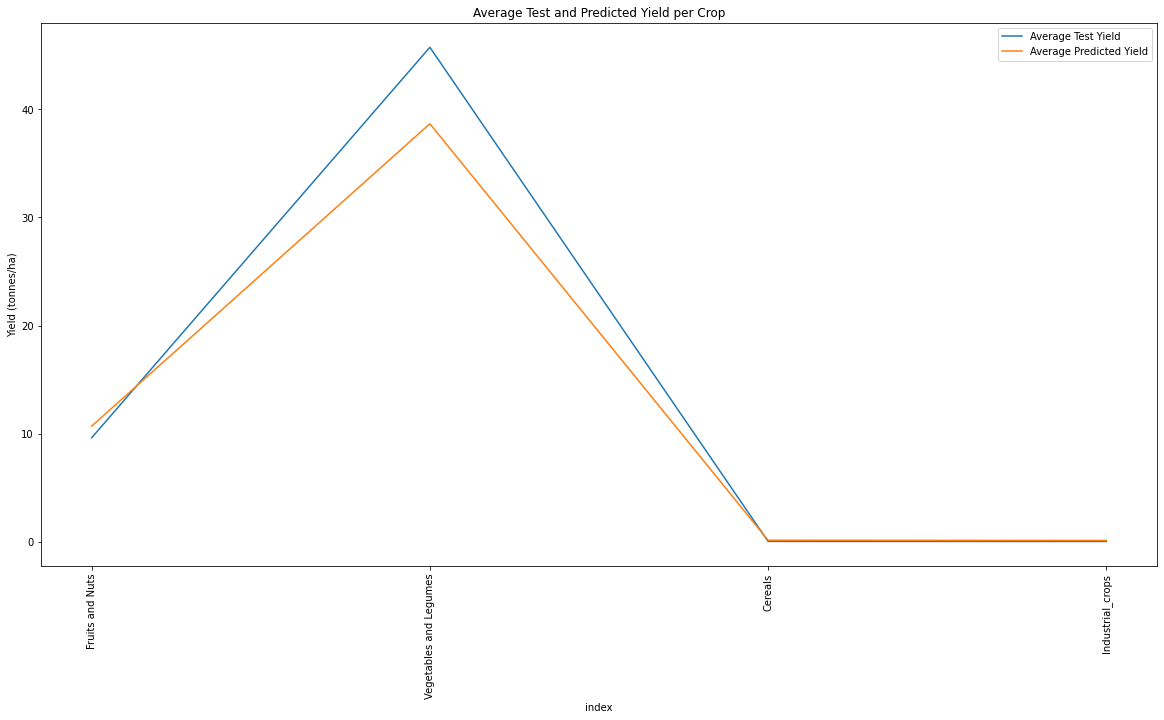

In [11]:
avg_df = error_df[['y_test_avg', 'y_pred_avg']].reset_index()



#create a line plot of the average test and predicted yield per crop
plt.figure(figsize=(20, 10))
plt.plot(avg_df['index'], avg_df['y_test_avg'], label='Average Test Yield')
plt.plot(avg_df['index'], avg_df['y_pred_avg'], label='Average Predicted Yield')
plt.xticks(rotation=90)
plt.xlabel('index')
plt.ylabel('Yield (tonnes/ha)')
plt.title('Average Test and Predicted Yield per Crop')
plt.legend()
plt.show()